# Training

Zoals eerder vermeld, zijn er twee basis stappen in machine learning:
1. Model training
2. Model inference

Op het moment dat we een model hebben gedefiniëerd, willen we de parameters aan de hand van de beschikbare data schatten. Dat doen we door het gepaste leer-algorithme toe te passen.
Dit noemen we **model training**.  
  
Een **getrained model is een model waarvan de parameters geschat zijn met behulp van een wel bepaalde traing dataset en optimalisatie-algorithme**.

Pas als het model getrained is, kan het gebruikt worden om effectief patroonherkenning te doen op _nieuwe data_. Die stap heet _model inference_.

:::{warning}
Het is niet omdat we een getraind model hebben, dat dit automatisch betekent dat het in staat is om de patronen te herkennen waar we naar op zoek zijn!  
**Onthou**: _All models are wrong, some are useful_.
:::

### Optimalisatie-algorithme
Een optimalisatie-algorithme heeft als doel om de optimale waarde voor een parameter te vinden, gegeven ons model (van de werkelijkheid) en de beschikbare data.
_Bij het uitvoeren van het optimalisatie-algorithme gebeurt dus het eigenlijke leren in ML_. Ook hier zijn vaak verschillende keuzes aan de orde.
Daarbij moeten we (a) effectiviteit om juiste parameterwaarden te vinden en (b) computationele efficientie tegen elkaar afgewegen.

:::{note} 🌍
:icon: false
:class: simple 
In ons eennvoudige airco voorbeeld kozen we voor het sample gemiddelde.
:::

De keuze van het algorithme hangt samen met het type model (lineair, neuraal netwerk, random forest, enz.) en, hoewel er voortdurend verder onderzoek gebeurd naar nieuwe technieken, zijn voor veel modellen geijkte keuzes beschikbaar. 
Zoals we in de uitgebreidere voorbeelden ook zullen zien, zijn leer- of optimalisatiealgorithmes vaak zeer complex (denk alvast aan het [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algoritme bij neurale netwerken en uitgebreid aan bod komt in de cursus Mathematical Foundations).  
In die complexiteit zit vaak ook nog het feit dat er verdere keuzes moeten gemaakt worden met betrekking tot de _specifieke configuratie van het algorithme zelf_.
Bij iteratieve methodes, bijvoorbeeld, waarin er stapsgewijs gezocht wordt naar een optimale waarde, moeten we een keuze maken over de grootte van die stappen (de zogenaamde _learning rate_).  
Die configuratie kan een grote impact hebben op de kwaliteit van het uiteindelijke resultaat. Het is vaak op voorhand ook niet duidelijk welke de beste configuratie voor het optimalisatie algorithme is, gegeven de specifieke situatie. Daarom wordt ook daar vaak op een (al dan niet principiële manier) iteratief gewerkt om tot optimale waarden te komen.  
**De numerieke configuratie parameters van een optimalisatiealgorithme worden _hyper parameters_ genoemd. Het process waarbij de hyper parameters worden geoptimaliseerd heeft _hyper parameter tuning_.**  
  
:::{note} 🌍
:icon: false
:class: simple 
Veronder stel dat we voor ons eenvoudigste model voor de airco temperatuur een **_online_ optimalisatie-algorithme** willen gebruiken (**optimalisatie gebeurt sequentieel na iedere observatie in een tijdsreeks**).
Dat zou er als volgt kunnen uitzien:
- We starten met een berekende gok, bv. $\hat{b_0} = 18$
- Van zodra de eerste observatie gemaakt wordt, bv. $d_0 = 25$, willen we onze initiële schatting updaten, maar we willen uiteraard niet gewoon de geobserveerde waarde overnemen.
- We kiezen voor de techniek van _expontial smoothing_ waarbij we op ieder moment een gewogen gemiddelde nemen tussen onze schatting van dat moment $\hat{b_i}$ en de nieuwe observatie $d_i$.
$$
\hat{b_{i+1}} = \hat{b_i}*(1-\lambda + d_i*(\lambda) \\
0 > \lambda > 1
$$

Hieronder visualiseren we dit voor verschillende waarden voor $\hat{b_0}$ en _learning rate_ $\lambda$.  
Merk op dat er een grote variatie is in de kwaliteit van de uiteindelijke schatting!
:::

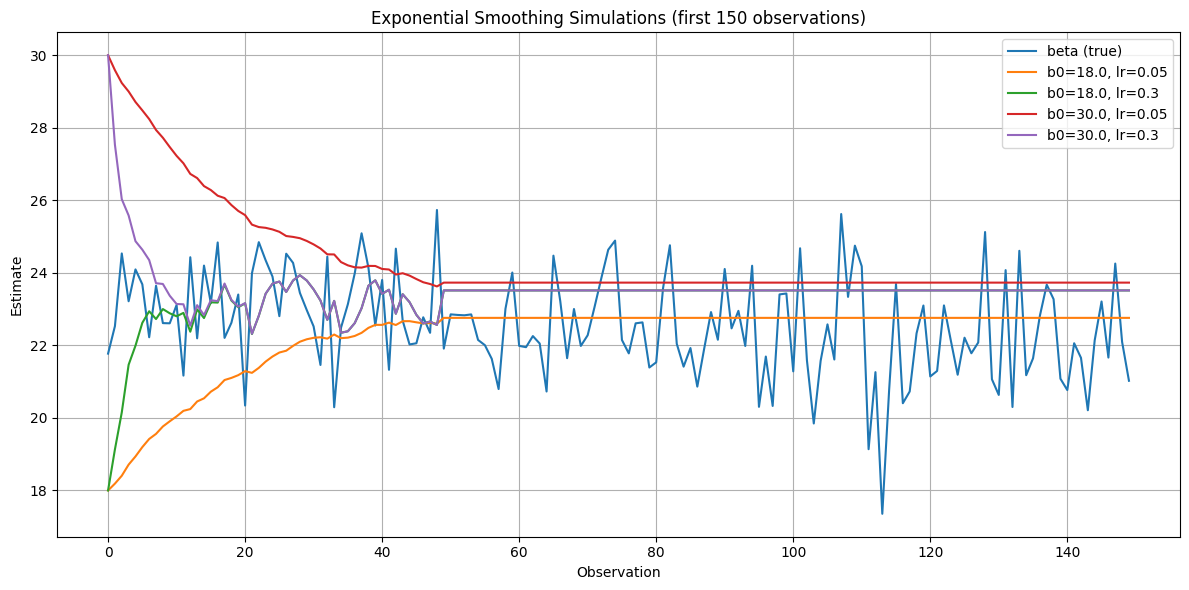

In [1]:
import matplotlib.pyplot as plt

from ml_courses.sim.airco import AircoSimulator

# Get the simulated preferences data
ac = AircoSimulator(seed=123)
df = ac.get_data()
y = df.beta.values

# Set the hyperparameters
b_0 = [18.0, 30.0]  # Initial estimate
lr = [0.05, 0.3]  # Learning rate
max_iter = 50  # Number of iterations

# Run the exponential smoothing algorithm for different configurations
n_sim = 0
for _b_0 in b_0:
    for _lr in lr:
        estimates = [_b_0]
        for i, d in enumerate(y):
            # stopping rule
            if i + 2 > max_iter:
                break
            _b_i = estimates[-1] * (1 - _lr) + float(d) * _lr
            estimates.append(_b_i)
        # If we stopped early, fill the rest with the last estimate
        estimates = estimates + [estimates[-1]] * (len(y) - max_iter)
        df[f"sim{n_sim}"] = estimates
        n_sim += 1

# Visualize the results
# Create labels for the different simulations
sim_labels = [
    f"b0={b_0[0]}, lr={lr[0]}",
    f"b0={b_0[0]}, lr={lr[1]}",
    f"b0={b_0[1]}, lr={lr[0]}",
    f"b0={b_0[1]}, lr={lr[1]}",
]

# Plot the true beta and the simulations
plt.figure(figsize=(12, 6))
plt.plot(df["beta"].iloc[:150], label="beta (true)")
for i, label in enumerate(sim_labels):
    plt.plot(df[f"sim{i}"].iloc[:150], label=label)
plt.xlabel("Observation")
plt.ylabel("Estimate")
plt.title("Exponential Smoothing Simulations (first 150 observations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

:::{note} 🌍
:icon: false
:class: simple
In dit algorithme spreken we dus over 2 **hyper parameters**: $\hat{b_0}$ en $\alpha$. De keuze daarvan heeft duidelijk drastische gevolgen voor de convergentie van het leerprocess.
Als we op een bepaald moment de schatting van de model parameter $\hat{b}$ willen vastzetten (zgn. _parameter freezing_), kunnen het algorithme ook uitbreiden met een zgn. _stopping rule_.
Die regel bepaald de voorwaarde om de updates te stoppen. Dat kan heel simpel door toevoeging van een hyper parameter die het maximum aantal updates bepaalt of door bijvoorbeeld een limiet te zetten op de _online_ update variantie (bv. [](https://doi.org/10.2307%2F1266577))
:::

### Verliesfunctie (_Loss function_)
De _Loss_ functie is ook gekend onder de namen _Error_ functie en _Cost_ functie. Er wordt in de domeinen van de wiskundige optimalisatie en beslissingstheorie ook soms gesproken over een _objectieve functie_.
Die verwijst ofwel naar een verliesfunctie of zijn tegengestelde vorm. Dan wordt er bijvoorbeeld ook gesproken over een _reward_ functie, _profit_ functie, _utility_ functie, _fitness_ functie, enz.
  
Bij het zoeken naar de optimale waarden voor de parameters in ons model, moeten we wiskundig kunnen uitdrukken wat _optimaliteit_ in een specifiek geval betekent om de _goodness of fit_ van de oplossing te kunnen uitdrukken - met andere woorden, we moeten de _optimaliteit_ van parameterschattingen op ieder momenent in een cijfer kunnen uitdrukken (kwantificeren). We moeten dus een functie beschrijven die optimaliteit uitdrukt. Het doel van het optimalisatie algorithme is om de output van die functie te maximaliseren.  
❗Om wiskundige redenen (die in de Mathematical Foundations cursus aan bod komen), draaien we de logica echter om en beschrijven we een functie die de _sub-optimaliteit_ uitdrukt. Die functie trachtten we dan te _minimaliseren_.  
  
**De _Loss_ functie is de wiskundige functie die de _sub-optimaliteit_ uitdrukt van parameterschattingen in een bepaalde context. Het doel van het optimalisatie-algorithme is om de output van die functie te _minimaliseren_.**

:::{note} 🌍
:icon: false
:class: simple
We nemen terug het geval van ons eenvoudige "airco model", waarbij we niet kiezen voor een online benadering van hier net boven, maar voor een **_batch_ optimalisatie-algorithme** (**de optimalisatie gebeurt door _tegelijk_ naar _alle_ observaties in de training data te kijken**). Een simpele definitie van optimaliteit hierbij is om op zoek te gaan naar de waarde die de kleinste afwijking heeft ten opzichte van alle observaties. Om in deze context _sub-optimaliteit_ uit te drukken als de output van een _Loss_ functie, wordt hier gekozen[^mathf] voor de zogenaamde **Sum of Squared Errors (SSE)** functie met als algemene vorm:
$$
J_{SSE}(f(\pmb{x}); \pmb{y}) = \sum_{i=1}^M(y_i-f(x_i))^2
$$
Deze formule stelt dat we voor elke door het model voorspelde output, $f(x_i)$, bepalen hoe _ver_ de voorspelling afligt van de werkelijke waarde $y_i$. Deze afstand wordt gekwantificeerd door eerst het verschil tussen de twee waarden te nemen en dit te kwadrateren. De gedachte hierachter is dat kleine fouten overeenkomen met kleine afstanden. Vervolgens worden alle $M$ afstanden over de gehele dataset samengevoegd door ze op te tellen. Dit resulteert in één enkel getal dat aangeeft hoe slecht de huidige parameterwaarden de structuur van de volledige dataset vastlegt. De beste set parameterschattingen minimaliseren de SSE en wordt in dit geval ook de kleinste-kwadratenoplossing (least sum of squares, LSS) genoemd.  
  
In ons voorbeeld krijgt deze _Loss_ functie de eenvoudige vorm:
$$
J_{SSE}(\hat{b}; \pmb{d}) = \sum_{i=1}^M(d_i-\hat{b})^2
$$
Het is eenvoudig te verifiëren dat deze functie geminimaliseerd wordt door het sample (of steekproef-)gemiddelde.
$$
J_{SSE}(\hat{b}; \pmb{d}) = \sum_{i=1}^M(d_i-\frac{\sum_{i=1}^M d_i}{M-1})^2
$$

[^mathf]: Om redenen die aan bod komen in de cursus Mathematical Foundations.
:::


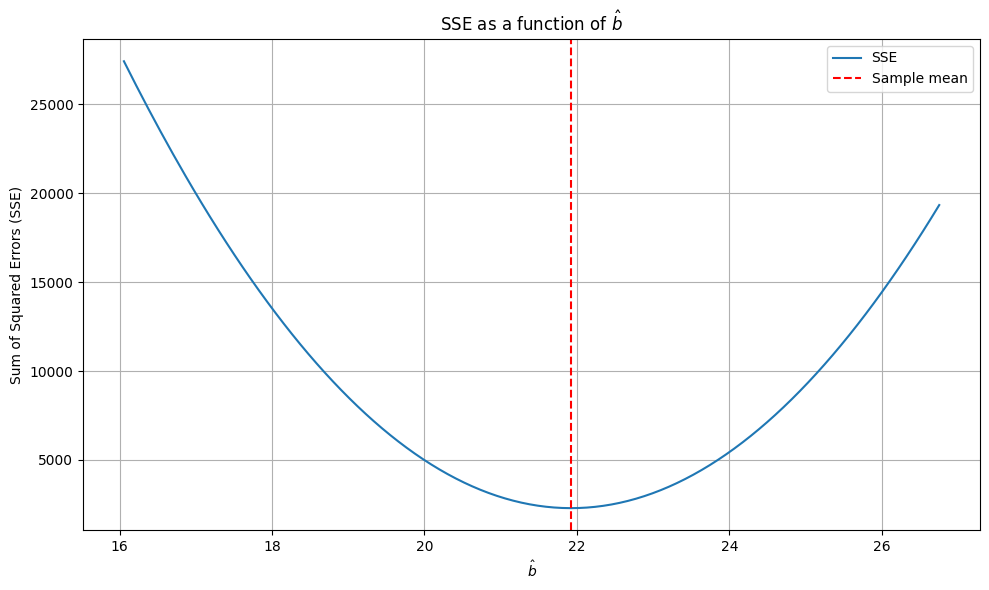

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from ml_courses.sim.airco import AircoSimulator

ac = AircoSimulator()
df = ac.get_data()
d = df.beta.values


# SSE function
def sse(d, b_hat):
    """
    Calculate the sum of squared errors (SSE) between observed values d and estimated values b_hat.

    Parameters
    ----------
    d : array-like
        Observed values.
    b_hat : float
        Estimated value

    Returns
    -------
    float
        The sum of squared errors.
    """
    return sum((d_i - b_hat) ** 2 for d_i in d)


# Range of b_hat values
b_hat_range = np.linspace(np.min(d), np.max(d), 200)
sse_values = [sse(d, b_hat) for b_hat in b_hat_range]

# Sample mean
sample_mean = np.mean(d)

plt.figure(figsize=(10, 6))
plt.plot(b_hat_range, sse_values, label="SSE")
plt.axvline(sample_mean, color="red", linestyle="--", label="Sample mean")
plt.xlabel(r"$\hat{b}$")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("SSE as a function of $\hat{b}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Supervisie